# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [42]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

data = pd.read_feather('/content/credit_scoring.ftr')
data.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [17]:
#separando o conjunto de dados para validação
df_oot = data.copy().query("data_ref >= '2016-01-01'")
df_oot.data_ref.unique()

<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [5]:
df = data.copy().query("data_ref < '2016-01-01'")
df.data_ref.unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00']
Length: 12, dtype: datetime64[ns]

In [6]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [7]:
df.mau.value_counts()

,count
mau,
False,563357
True,36643


In [8]:
# Cria um DataFrame 'df_amostra' que contém todas as linhas onde 'mau' é 1 (inadimplente) e uma amostra aleatória de 390 linhas onde 'mau' é 0 (não inadimplente)

df_amostra = pd.concat([df[df.mau==1], df[df.mau==0].sample(n=390)])
tab_am = df_amostra.mau.value_counts()
tab_pop = df.mau.value_counts()
rho_mau = tab_am.iloc[1]/tab_am.sum()
rho_bom = tab_am.iloc[0]/tab_am.sum()

pi_mau = tab_pop.iloc[1]/tab_pop.sum()
pi_bom = tab_pop.iloc[0]/tab_pop.sum()

wbom = pi_bom*rho_bom
wmau = pi_mau*rho_mau

df_amostra.loc[df_amostra.mau == 1,'w']=wmau
df_amostra.loc[df_amostra.mau == 0,'w']=wbom

df_amostra.groupby('mau')['w'].sum()/df_amostra.w.sum()

,w
mau,
False,0.938928
True,0.061072


In [9]:
variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau']

In [11]:
# Define uma função para calcular o Information Value (IV) de uma variável
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

metadados = pd.DataFrame(df[variaveis].dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002665
posse_de_veiculo,object,0.0,2.0,covariavel,0.000075
posse_de_imovel,object,0.0,2.0,covariavel,0.009690
qtd_filhos,int64,0.0,8.0,covariavel,0.000055
tipo_renda,object,0.0,5.0,covariavel,0.009718
educacao,object,0.0,5.0,covariavel,0.003690
estado_civil,object,0.0,5.0,covariavel,0.001305
tipo_residencia,object,0.0,6.0,covariavel,0.003330
idade,int64,0.0,47.0,covariavel,0.018434
tempo_emprego,float64,100875.0,3004.0,covariavel,0.360581


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [12]:
df.groupby('data_ref').count()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,,
2015-01-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41508,50000,50000,50000
2015-02-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41583,50000,50000,50000
2015-03-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41773,50000,50000,50000
2015-04-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41577,50000,50000,50000
2015-05-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41647,50000,50000,50000
2015-06-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41658,50000,50000,50000
2015-07-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41391,50000,50000,50000
2015-08-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41557,50000,50000,50000
2015-09-01,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,41563,50000,50000,50000


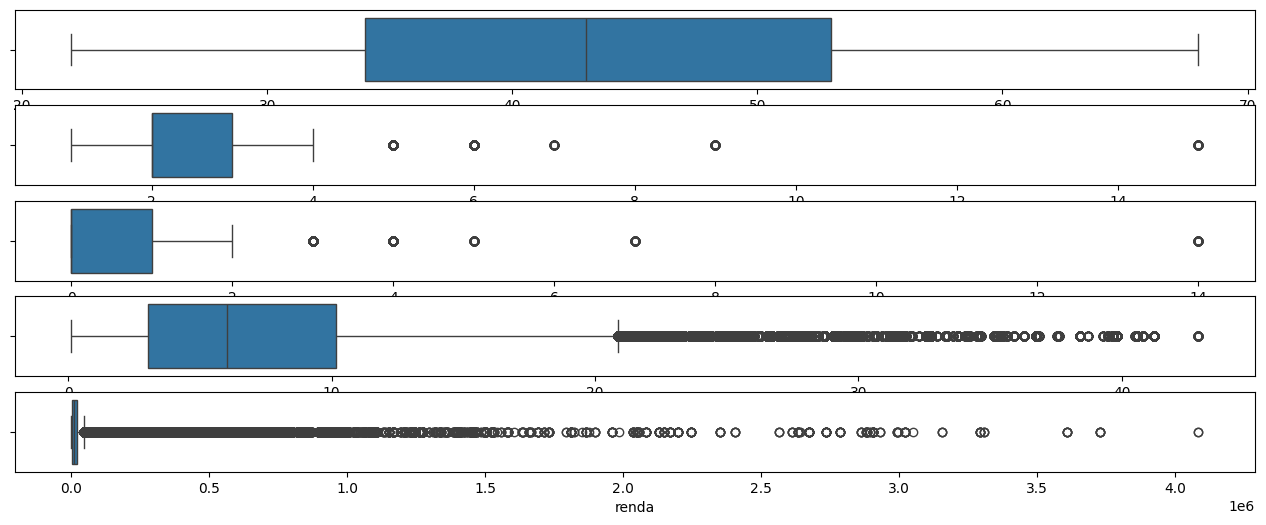

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 6))
continuas = ['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'tempo_emprego', 'renda']
for i, var in enumerate(continuas):
    sns.boxplot(ax=axes[i], x=df[var])

<Axes: xlabel='renda'>

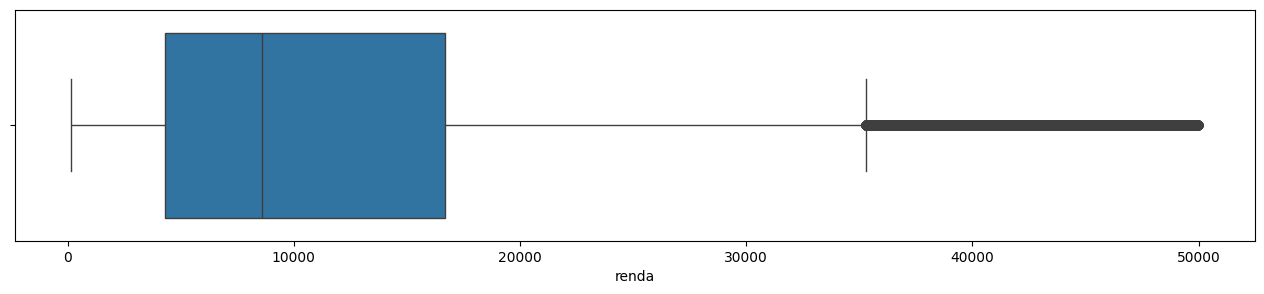

In [14]:
df = df.query('renda < 50000')
df_oot = df_oot.query('renda < 50000')

fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(ax=ax, x=df['renda'])

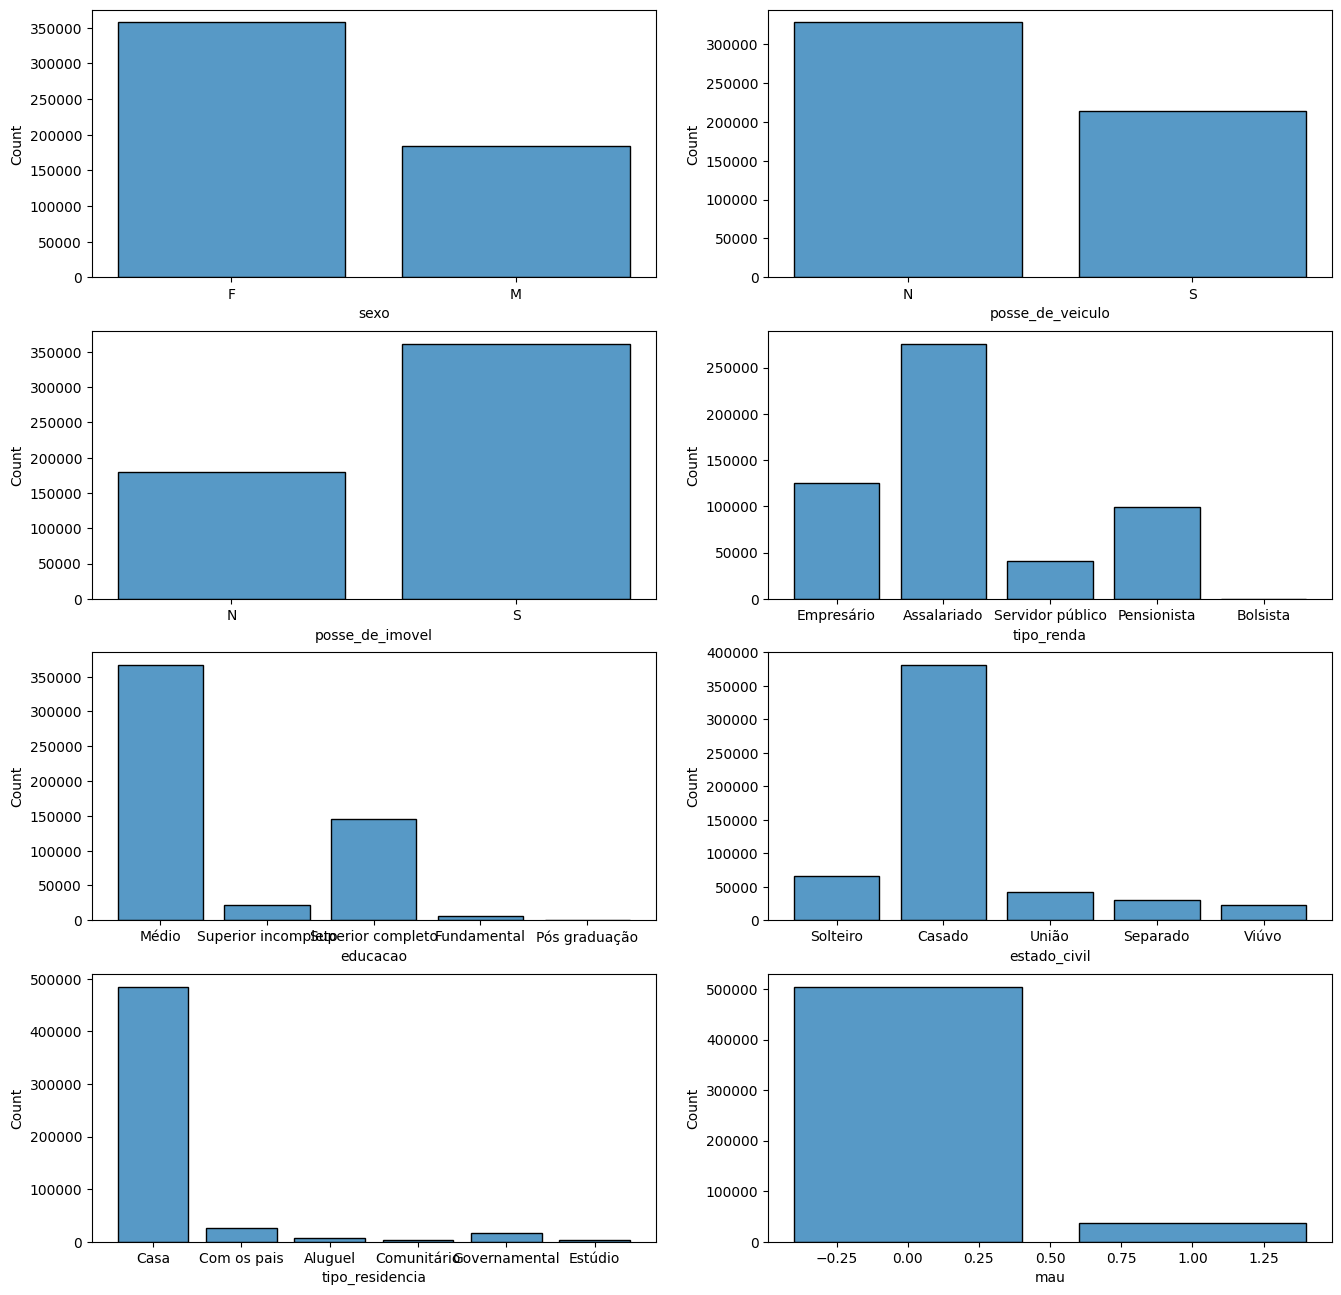

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
discretas = [var for var in variaveis if var not in continuas]

for i, var in enumerate(discretas):
    sns.histplot(ax=axes[i//2][i%2], x=df[var], binwidth=.5, discrete=True, shrink=.8)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [16]:
# Define uma função para calcular e exibir informações bivariadas para uma variável categórica (discreta)
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()

    return display(biv)

# Define uma função para calcular e exibir informações bivariadas para uma variável contínua

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return display(biv)

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,332256,25306,0.070774,F,357562,0.000429,0.071614,0.069933,-2.574864,-2.562152,-2.587716,0.055154,0.067866,0.042302
M,172703,11090,0.060340,M,183793,0.000555,0.061428,0.059251,-2.745530,-2.726490,-2.764894,-0.115511,-0.096471,-0.134875


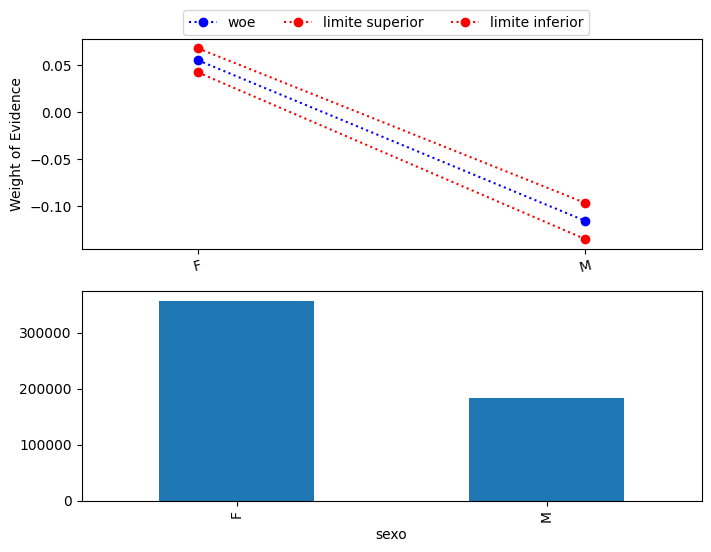

In [18]:
biv_discreta(discretas[0], df);

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,305169,22358,0.068263,N,327527,0.000441,0.069127,0.067399,-2.613682,-2.600181,-2.627341,0.016337,0.029837,0.002677
S,199790,14038,0.065651,S,213828,0.000536,0.066701,0.064601,-2.655499,-2.638511,-2.672741,-0.025481,-0.008493,-0.042723


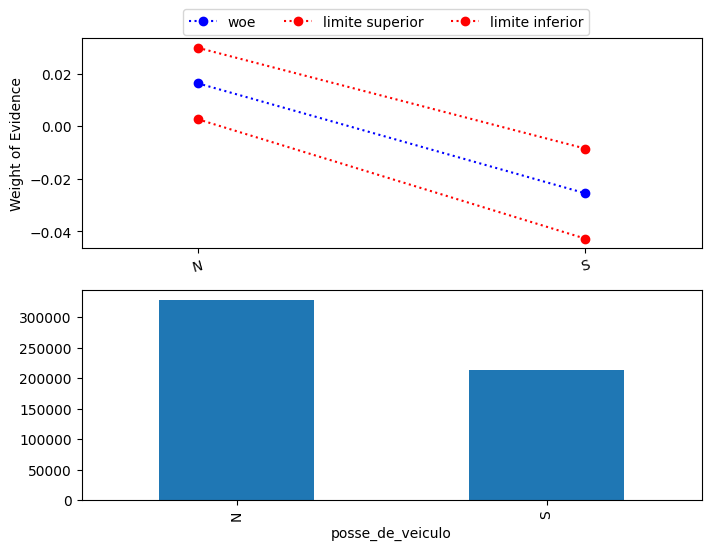

In [19]:
biv_discreta(discretas[1], df);

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,166477,13560,0.075318,N,180037,0.000622,0.076537,0.074099,-2.507733,-2.490358,-2.525368,0.122285,0.139660,0.104650
S,338482,22836,0.063202,S,361318,0.000405,0.063995,0.062409,-2.696133,-2.682810,-2.709612,-0.066114,-0.052792,-0.079594


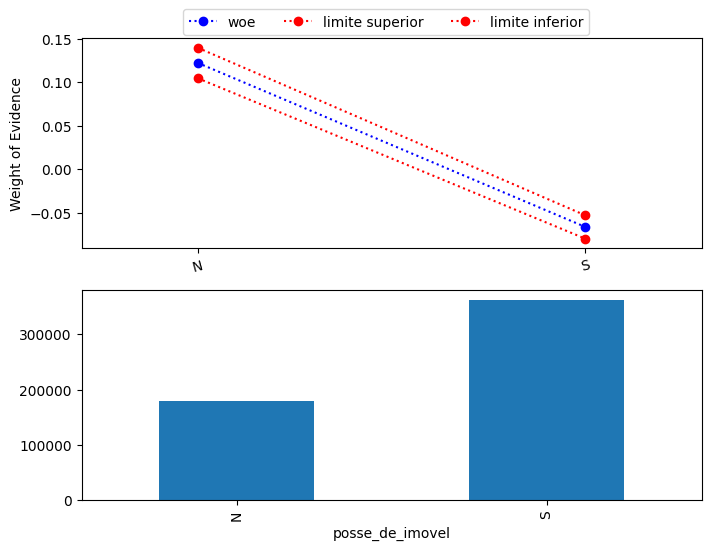

In [20]:
biv_discreta(discretas[2], df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,256282,19452,0.070546,Assalariado,275734,0.000488,0.071502,0.069590,-2.578329,-2.563842,-2.592997,0.051690,0.066176,0.037021
Bolsista,242,12,0.047244,Bolsista,254,0.013312,0.073461,0.021027,-3.004031,-2.534704,-3.840678,-0.374013,0.095314,-1.210660
Empresário,116695,8147,0.065258,Empresário,124842,0.000699,0.066629,0.063888,-2.661914,-2.639670,-2.684596,-0.031896,-0.009652,-0.054578
Pensionista,92760,6489,0.065381,Pensionista,99249,0.000785,0.066919,0.063843,-2.659907,-2.635010,-2.685355,-0.029889,-0.004992,-0.055336
Servidor público,38980,2296,0.055626,Servidor público,41276,0.001128,0.057837,0.053414,-2.831880,-2.790555,-2.874781,-0.201862,-0.160537,-0.244763


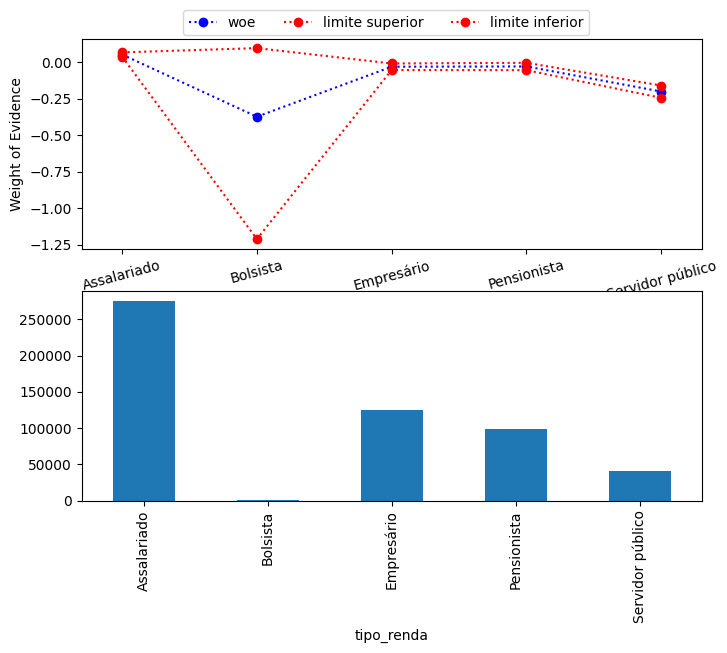

In [21]:
biv_discreta(discretas[3], df);

<ipython-input-22-ac88c25a8f3f>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
<ipython-input-22-ac88c25a8f3f>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado/Bolsista,256524,19464,0.070525,Assalariado/Bolsista,275988,0.000487,0.071480,0.069570,-2.578656,-2.564174,-2.593320,0.051363,0.065844,0.036699
Empresário,116695,8147,0.065258,Empresário,124842,0.000699,0.066629,0.063888,-2.661914,-2.639670,-2.684596,-0.031896,-0.009652,-0.054578
Pensionista,92760,6489,0.065381,Pensionista,99249,0.000785,0.066919,0.063843,-2.659907,-2.635010,-2.685355,-0.029889,-0.004992,-0.055336
Servidor público,38980,2296,0.055626,Servidor público,41276,0.001128,0.057837,0.053414,-2.831880,-2.790555,-2.874781,-0.201862,-0.160537,-0.244763


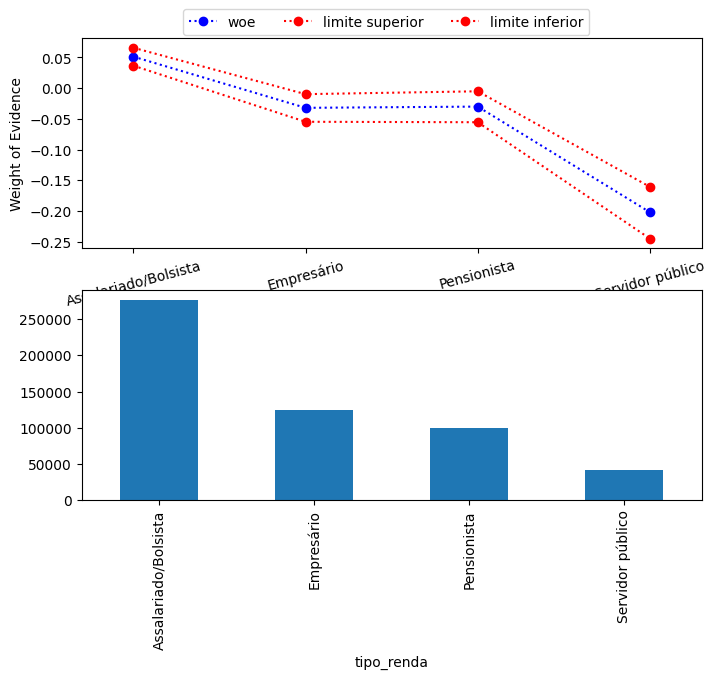

In [22]:
df2 = df.copy()
df_oot2 = df_oot.copy()
df2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
df_oot2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
biv_discreta('tipo_renda', df2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6162,479,0.072128,Fundamental,6641,0.003175,0.078351,0.065905,-2.554456,-2.464969,-2.651370,0.075562,0.165050,-0.021352
Médio,341281,25343,0.069125,Médio,366624,0.000419,0.069946,0.068304,-2.600204,-2.587513,-2.613035,0.029815,0.042506,0.016983
Pós graduação,572,43,0.069919,Pós graduação,615,0.010283,0.090113,0.049725,-2.587939,-2.312258,-2.950252,0.042079,0.317760,-0.320234
Superior completo,136666,9018,0.061901,Superior completo,145684,0.000631,0.063139,0.060664,-2.718317,-2.697204,-2.739829,-0.088299,-0.067186,-0.109810
Superior incompleto,20278,1513,0.069432,Superior incompleto,21791,0.001722,0.072807,0.066057,-2.595442,-2.544343,-2.648894,0.034576,0.085675,-0.018875


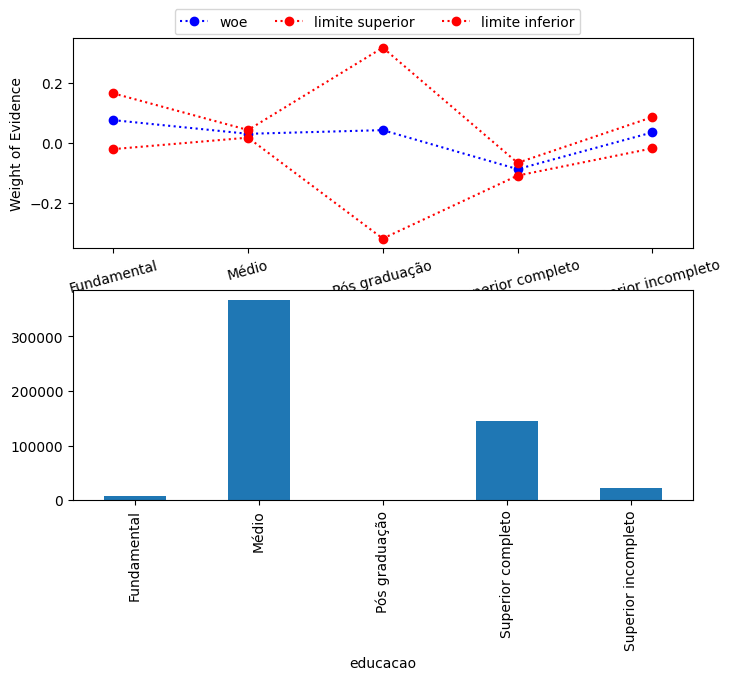

In [23]:
biv_discreta(discretas[4], df);

<ipython-input-24-f7ee82b6514e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
<ipython-input-24-f7ee82b6514e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,347443,25822,0.069179,Fundamental/Médio,373265,0.000415,0.069993,0.068365,-2.599374,-2.586800,-2.612085,0.030645,0.043218,0.017933
Superior,157516,10574,0.062907,Superior,168090,0.000592,0.064067,0.061746,-2.701129,-2.681607,-2.720990,-0.071111,-0.051588,-0.090972


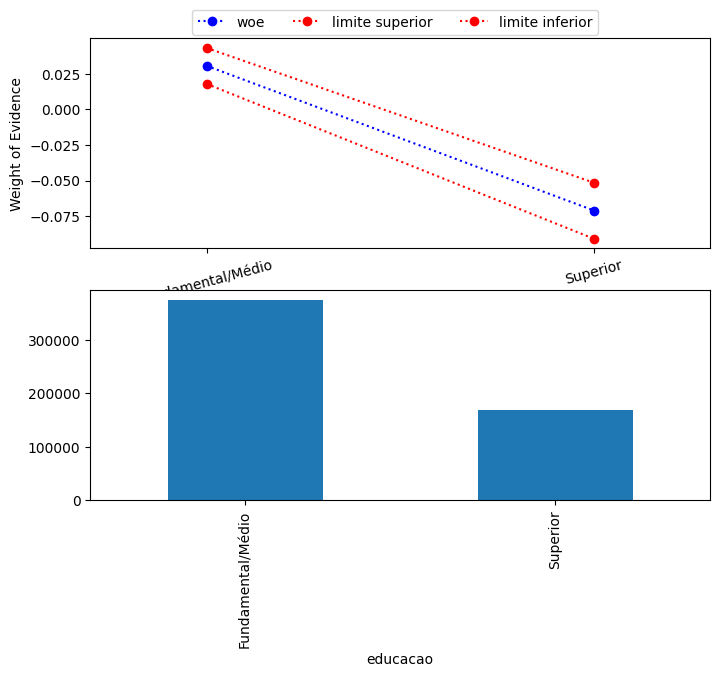

In [24]:
df2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
df_oot2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df_oot2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,355991,25103,0.065871,Casado,381094,0.000402,0.066658,0.065083,-2.651918,-2.639189,-2.664789,-0.021900,-0.009171,-0.034771
Separado,27851,2182,0.072653,Separado,30033,0.001498,0.075589,0.069718,-2.546627,-2.503844,-2.591034,0.083391,0.126174,0.038984
Solteiro,61258,4600,0.069847,Solteiro,65858,0.000993,0.071794,0.067901,-2.589038,-2.559453,-2.619396,0.040980,0.070565,0.010623
União,38400,3036,0.073270,União,41436,0.001280,0.075779,0.070761,-2.537517,-2.501135,-2.575065,0.092502,0.128884,0.054954
Viúvo,21459,1475,0.064315,Viúvo,22934,0.001620,0.067490,0.061140,-2.677486,-2.625900,-2.731501,-0.047468,0.004119,-0.101483


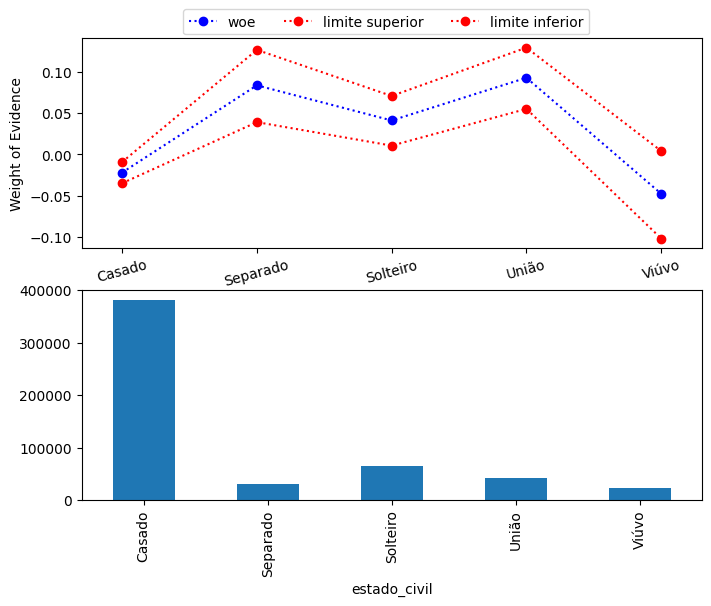

In [25]:
biv_discreta(discretas[5], df);

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7131,594,0.076893,Aluguel,7725,0.003031,0.082835,0.070951,-2.485327,-2.404433,-2.572170,0.144691,0.225585,0.057849
Casa,453424,32221,0.066347,Casa,485645,0.000357,0.067047,0.065647,-2.644209,-2.632964,-2.655565,-0.014191,-0.002946,-0.025547
Com os pais,23322,1988,0.078546,Com os pais,25310,0.001691,0.081861,0.075232,-2.462268,-2.417332,-2.508973,0.167750,0.212686,0.121045
Comunitário,2265,185,0.075510,Comunitário,2450,0.005338,0.085977,0.065043,-2.504974,-2.363770,-2.665453,0.125044,0.266249,-0.035435
Estúdio,3630,223,0.057877,Estúdio,3853,0.003762,0.065252,0.050501,-2.789816,-2.662012,-2.933931,-0.159798,-0.031994,-0.303913
Governamental,15187,1185,0.072380,Governamental,16372,0.002025,0.076349,0.068410,-2.550697,-2.493019,-2.611369,0.079321,0.137000,0.018649


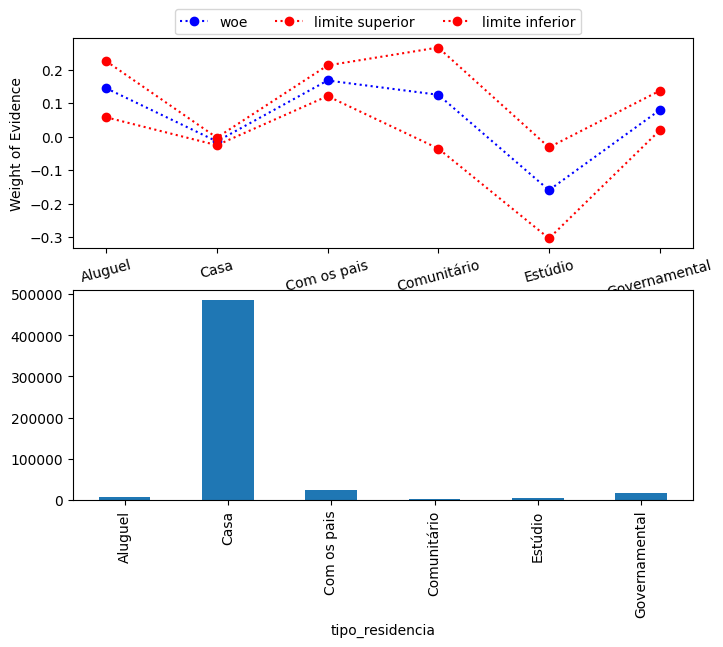

In [26]:
biv_discreta(discretas[6], df);

<ipython-input-16-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 32.0]",105757,8738,0.076318,28.779571,114495,0.000785,0.077856,0.074780,-2.493463,-2.471845,-2.515484,0.136556,0.158173,0.114535
"(32.0, 39.0]",105502,7695,0.067979,36.016529,113197,0.000748,0.069445,0.066512,-2.618159,-2.595243,-2.641538,0.011859,0.034775,-0.011519
"(39.0, 46.0]",96690,6730,0.065074,42.846393,103420,0.000767,0.066578,0.063571,-2.664935,-2.640487,-2.689914,-0.034916,-0.010469,-0.059895
"(46.0, 55.0]",97809,6421,0.061604,50.860635,104230,0.000745,0.063064,0.060144,-2.723443,-2.698468,-2.748977,-0.093424,-0.068450,-0.118958
"(55.0, 68.0]",99201,6812,0.064256,60.494902,106013,0.000753,0.065732,0.062780,-2.678462,-2.654172,-2.703278,-0.048444,-0.024153,-0.073260


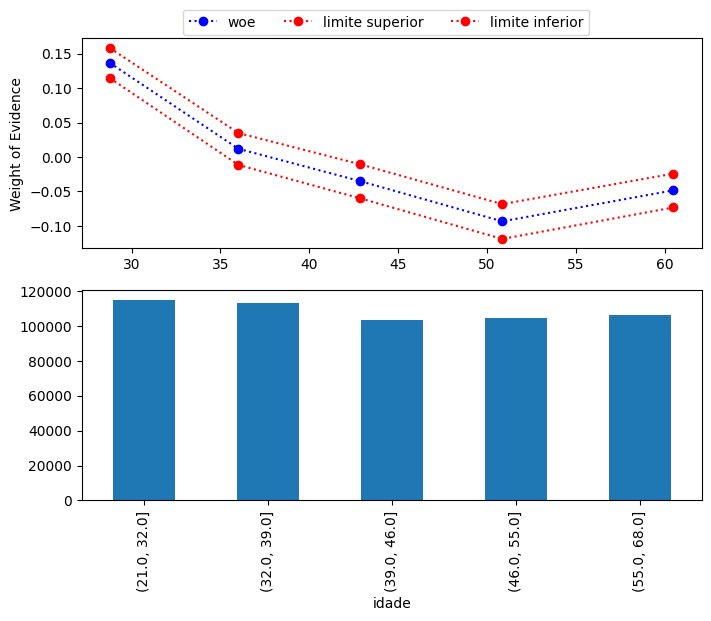

In [27]:
biv_continua(continuas[0], 5, df);

<ipython-input-16-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",362643,25848,0.066534,1.748802,388491,0.000400,0.067318,0.065751,-2.641186,-2.628636,-2.653873,-0.011167,0.001382,-0.023855
"(2.0, 3.0]",89971,6779,0.070067,3.000000,96750,0.000821,0.071676,0.068459,-2.585658,-2.561230,-2.610610,0.044361,0.068788,0.019409
"(3.0, 4.0]",45730,3245,0.066258,4.000000,48975,0.001124,0.068461,0.064055,-2.645639,-2.610570,-2.681809,-0.015621,0.019448,-0.051791
"(4.0, 15.0]",6615,524,0.073400,5.264463,7139,0.003087,0.079450,0.067349,-2.535603,-2.449841,-2.628142,0.094415,0.180178,0.001876


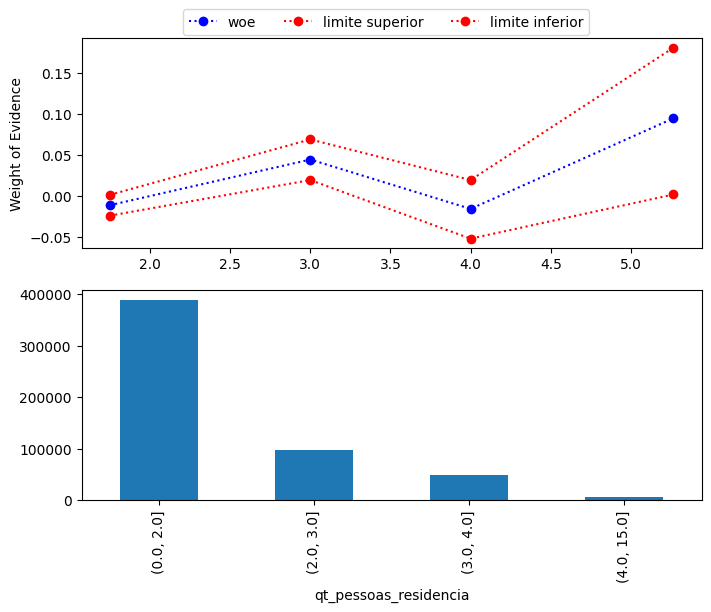

In [28]:
biv_continua(continuas[1], 12, df);

<ipython-input-16-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
"(-1.0, 1.0]",450393,32452,0.067210,0.233640,482845,0.000360,0.067916,0.066504,-2.630358,-2.619148,-2.641679,-0.000340,0.010870,-0.011661
"(1.0, 2.0]",47711,3402,0.066558,2.000000,51113,0.001103,0.068719,0.064397,-2.640798,-2.606530,-2.676116,-0.010780,0.023488,-0.046098
"(2.0, 14.0]",6855,542,0.073273,3.269704,7397,0.003030,0.079212,0.067334,-2.537468,-2.453098,-2.628388,0.092551,0.176920,0.001630


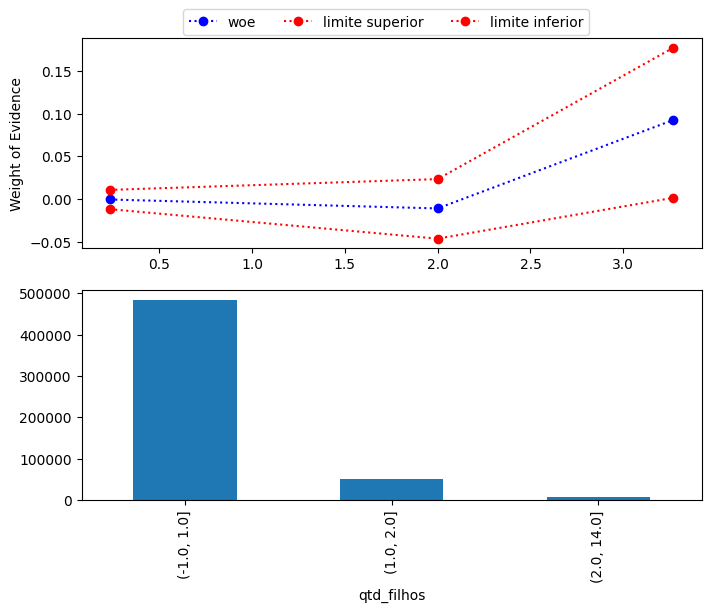

In [29]:
biv_continua(continuas[2], 10, df);

<ipython-input-16-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 2.0]",79404,9279,0.104631,1.126105,88683,0.001028,0.106646,0.102617,-2.146795,-2.125472,-2.168483,0.483223,0.504546,0.461535
"(2.0, 4.0]",80785,7488,0.084828,3.228584,88273,0.000938,0.086666,0.082990,-2.378490,-2.355042,-2.402402,0.251529,0.274976,0.227616
"(4.0, 7.0]",82597,5968,0.067386,5.345136,88565,0.000842,0.069037,0.065734,-2.627561,-2.601584,-2.654137,0.002457,0.028435,-0.024118
"(7.0, 10.0]",83924,4457,0.050429,7.966703,88381,0.000736,0.051872,0.048987,-2.935436,-2.905708,-2.965980,-0.305417,-0.275690,-0.335961
"(10.0, 41.0]",85719,2737,0.030942,13.806707,88456,0.000582,0.032083,0.029801,-3.444212,-3.406818,-3.482966,-0.814194,-0.776799,-0.852948


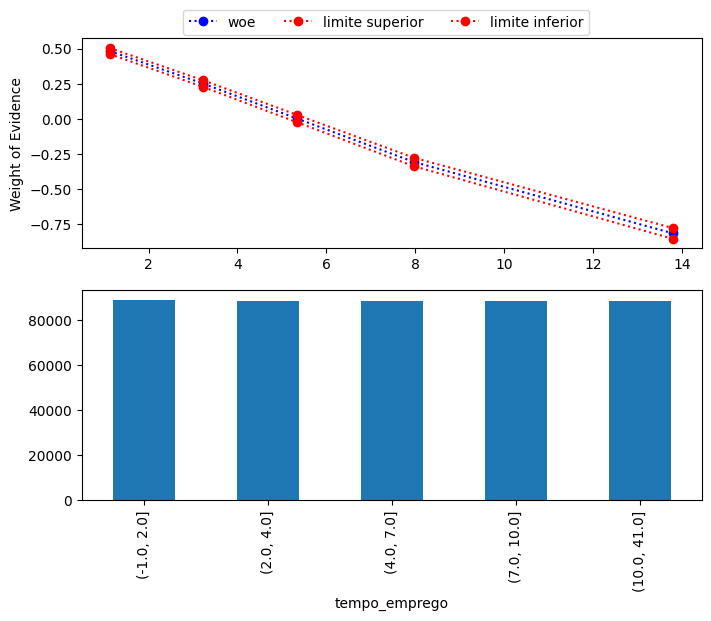

In [30]:
biv_continua(continuas[3], 5, df);

<ipython-input-16-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 3606.0]",89578,18700,0.172704,2253.101343,108278,0.001149,0.174955,0.170452,-1.566586,-1.550909,-1.582426,1.063432,1.079110,1.047592
"(3606.0, 6625.0]",100120,8145,0.075232,5045.114970,108265,0.000802,0.076803,0.073661,-2.508965,-2.486595,-2.531768,0.121053,0.143423,0.098250
"(6625.0, 11129.0]",103288,4985,0.046041,8696.816084,108273,0.000637,0.047289,0.044793,-3.031088,-3.003026,-3.059883,-0.401069,-0.373008,-0.429865
"(11129.0, 19498.0]",105235,3034,0.028023,14750.703026,108269,0.000502,0.029006,0.027040,-3.546314,-3.510822,-3.583036,-0.916296,-0.880804,-0.953018
"(19498.0, 49998.0]",106738,1532,0.014150,30184.704138,108270,0.000359,0.014853,0.013446,-4.243803,-4.194566,-4.295515,-1.613785,-1.564548,-1.665497


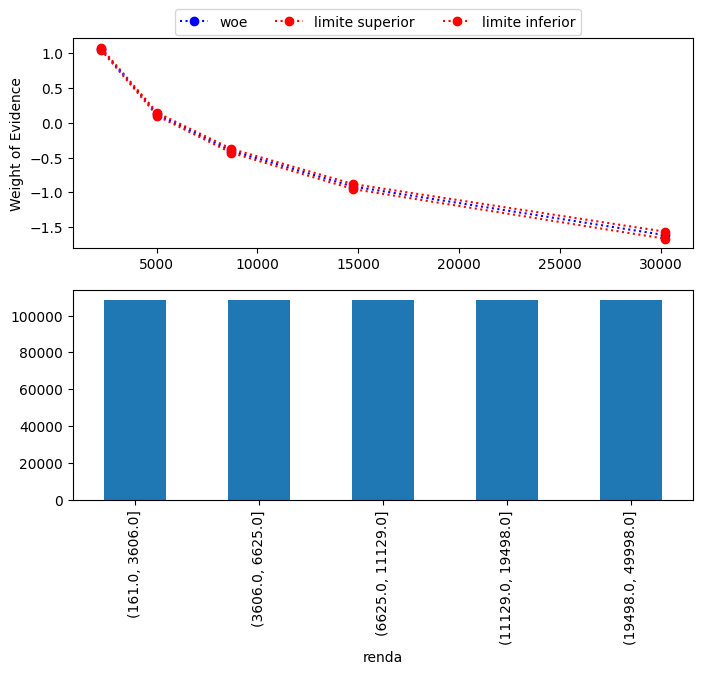

In [31]:
biv_continua(continuas[4], 5, df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [32]:
df2['tempo_emprego'] = df2['tempo_emprego'].fillna(df2['tempo_emprego'].mean())
df2.isna().sum()

,0
data_ref,0
index,0
sexo,0
posse_de_veiculo,0
posse_de_imovel,0
qtd_filhos,0
tipo_renda,0
educacao,0
estado_civil,0
tipo_residencia,0


In [33]:
" + ".join(df2[variaveis].columns[:-1])

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda'

In [34]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,112472.0,covariavel,0.959826
tempo_emprego,float64,100875.0,3004.0,covariavel,0.360581
idade,int64,0.0,47.0,covariavel,0.018434
tipo_renda,object,0.0,5.0,covariavel,0.009718
posse_de_imovel,object,0.0,2.0,covariavel,0.009690
educacao,object,0.0,5.0,covariavel,0.003690
tipo_residencia,object,0.0,6.0,covariavel,0.003330
sexo,object,0.0,2.0,covariavel,0.002665
estado_civil,object,0.0,5.0,covariavel,0.001305
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001263


In [35]:
formula = 'mau ~ idade + tempo_emprego + renda'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               541355
Model:                                     GLM   Df Residuals:                   541351
Model Family:                         Binomial   Df Model:                            3
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2191e+05
Date:                         Sun, 10 Nov 2024   Deviance:                   2.4381e+05
Time:                                 22:25:08   Pearson chi2:                 9.78e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.04157
Covariance Type:                     nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4589      0.022     66.453      0.000       1.416       1.502
idade             0.0004      0.000      0.816      0.415      -0.001       0.001
tempo_emprego     0.0179      0.002      9.825      0.000       0.014       0.021
renda             0.0001   1.24e-06    104.408      0.000       0.000       0.000
=================================================================================
"""

In [36]:
formula = 'mau ~ tempo_emprego + renda'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               541355
Model:                                     GLM   Df Residuals:                   541352
Model Family:                         Binomial   Df Model:                            2
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2191e+05
Date:                         Sun, 10 Nov 2024   Deviance:                   2.4381e+05
Time:                                 22:25:26   Pearson chi2:                 9.79e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.04157
Covariance Type:                     nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4744      0.011    134.738      0.000       1.453       1.496
tempo_emprego     0.0182      0.002     10.196      0.000       0.015       0.022
renda             0.0001   1.24e-06    104.407      0.000       0.000       0.000
=================================================================================
"""

In [37]:
formula = 'mau ~ tipo_renda + tempo_emprego + renda'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               541355
Model:                                     GLM   Df Residuals:                   541349
Model Family:                         Binomial   Df Model:                            5
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2190e+05
Date:                         Sun, 10 Nov 2024   Deviance:                   2.4380e+05
Time:                                 22:25:47   Pearson chi2:                 9.76e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.04160
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.4577      0.012    123.222      0.000       1.434       1.481
tipo_renda[T.Empresário]           0.0423      0.014      3.029      0.002       0.015       0.070
tipo_renda[T.Pensionista]          0.0509      0.015      3.315      0.001       0.021       0.081
tipo_renda[T.Servidor público]     0.0270      0.023      1.161      0.246      -0.019       0.073
tempo_emprego                      0.0175      0.002      9.577      0.000       0.014       0.021
renda                              0.0001   1.24e-06    104.190      0.000       0.000       0.000
==================================================================================================
"""

In [38]:
formula = 'mau ~ sexo + tipo_renda + tempo_emprego + np.log(renda)'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               541355
Model:                                     GLM   Df Residuals:                   541348
Model Family:                         Binomial   Df Model:                            6
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1872e+05
Date:                         Sun, 10 Nov 2024   Deviance:                   2.3743e+05
Time:                                 22:26:08   Pearson chi2:                 5.42e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.05280
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -5.8996      0.053   -112.213      0.000      -6.003      -5.797
sexo[T.M]                         -0.0006      0.012     -0.050      0.960      -0.025       0.024
tipo_renda[T.Empresário]           0.0033      0.014      0.233      0.816      -0.025       0.031
tipo_renda[T.Pensionista]         -0.0106      0.016     -0.671      0.502      -0.042       0.020
tipo_renda[T.Servidor público]    -0.0069      0.024     -0.290      0.772      -0.053       0.039
tempo_emprego                      0.0016      0.002      0.898      0.369      -0.002       0.005
np.log(renda)                      0.9871      0.007    147.052      0.000       0.974       1.000
==================================================================================================
"""

In [39]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df2['tempo_emprego_norm'] = sc_X.fit_transform(df2[['tempo_emprego']])
df2['renda_norm'] = sc_X.fit_transform(df2[['renda']])
df_oot2['tempo_emprego_norm'] = sc_X.fit_transform(df_oot2[['tempo_emprego']])
df_oot2['renda_norm'] = sc_X.fit_transform(df_oot2[['renda']])

formula = 'mau ~ sexo + tipo_renda + tempo_emprego_norm + renda_norm'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               541355
Model:                                     GLM   Df Residuals:                   541348
Model Family:                         Binomial   Df Model:                            6
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2188e+05
Date:                         Sun, 10 Nov 2024   Deviance:                   2.4375e+05
Time:                                 22:26:19   Pearson chi2:                 9.65e+05
No. Iterations:                              8   Pseudo R-squ. (CS):            0.04168
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.1081      0.012    260.049      0.000       3.085       3.132
sexo[T.M]                          0.0847      0.012      6.907      0.000       0.061       0.109
tipo_renda[T.Empresário]           0.0475      0.014      3.399      0.001       0.020       0.075
tipo_renda[T.Pensionista]          0.0719      0.016      4.596      0.000       0.041       0.103
tipo_renda[T.Servidor público]     0.0324      0.023      1.389      0.165      -0.013       0.078
tempo_emprego_norm                 0.0767      0.008      9.732      0.000       0.061       0.092
renda_norm                         1.3732      0.013    103.468      0.000       1.347       1.399
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [40]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 6.72%
KS: 36.66% 
AUC: 25.31% 
GINI: -49.38%


In [41]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df_oot2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 26.15%
KS: 34.62% 
AUC: 26.43% 
GINI: -47.13%
